In [29]:
#!pip install pandas_profiling

# Libraries and Global Settings

In [30]:
import pandas as pd  # work with Pandas dataframes
from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats

from sklearn import preprocessing

from keras import layers
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import RMSprop

import warnings # Funktionalität zur Unterdrückung von Warnungen
warnings.filterwarnings('ignore')

In [31]:
%%html
<style>
table {float:left}
</style>

# Importing Data

Fist of all we import the data which were generated in the whole preprocess (`df_for_ML`).

In [32]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [33]:
df_for_ML = pd.read_csv('df_for_ML.csv', parse_dates=['Datum'], date_parser=dateparse)

In [34]:
df_for_ML.Datum[0]

Timestamp('2000-01-01 00:00:00')

In [35]:
df_for_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7458 entries, 0 to 7457
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datum         7458 non-null   datetime64[ns]
 1   Temp          7458 non-null   float64       
 2   WG            7458 non-null   float64       
 3   WR            7458 non-null   float64       
 4   Druck         7458 non-null   float64       
 5   NO            7458 non-null   float64       
 6   NO2           7458 non-null   float64       
 7   SO2           7458 non-null   float64       
 8   CO            7458 non-null   float64       
 9   Niederschlag  7458 non-null   float64       
 10  PM10          7458 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 641.0 KB


In [36]:
df_for_ML=df_for_ML.sort_values(by=['Datum'], axis=0, ascending=True, ignore_index=True)
df_for_ML

,Datum,Temp,WG,WR,Druck,NO,NO2,SO2,CO,Niederschlag,PM10
0,2000-01-01,3.718,1.959896,234.922917,991.80,17.6266,24.236,10.38000,0.910900,3.5892,11.3772
1,2000-01-02,3.848,2.172912,222.511250,996.90,14.2886,28.698,10.74000,0.887000,3.5212,12.3972
2,2000-01-03,1.463,2.295208,220.181250,996.20,19.0638,35.336,10.29000,0.839400,0.8398,19.9480
3,2000-01-04,4.934,3.574979,220.885417,989.90,8.2660,24.210,13.42000,0.782200,1.4894,11.4780
4,2000-01-05,6.917,2.237208,220.554167,989.70,11.3496,26.208,14.27000,1.189000,4.3200,12.9260
...,...,...,...,...,...,...,...,...,...,...,...
7453,2020-05-27,17.300,1.700000,212.000000,1000.09,6.1000,21.700,11.71520,0.136966,0.0000,12.1060
7454,2020-05-28,17.300,2.400000,28.000000,996.45,4.2000,23.500,2.13052,0.119944,0.0000,13.9400
7455,2020-05-29,16.200,2.200000,129.000000,993.43,2.8000,18.700,8.79640,0.173780,0.0000,21.6300
7456,2020-05-30,15.900,2.400000,27.000000,989.46,2.4000,18.400,2.93716,0.130298,0.0000,13.1080


In [37]:
type(df_for_ML.Datum[0])

pandas._libs.tslibs.timestamps.Timestamp

In [38]:
df_for_ML.describe()

,Temp,WG,WR,Druck,NO,NO2,SO2,CO,Niederschlag,PM10
count,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000
mean,12.037186,1.981211,194.085750,984.837622,20.628170,33.558937,6.631525,0.455946,1.429776,19.585107
std,7.414490,0.727090,61.500193,7.725808,26.766503,16.107154,4.776749,0.296478,3.356878,11.001963
min,-11.430000,0.600000,2.300000,947.400000,0.047220,0.000000,0.000000,0.023830,0.000000,0.000000
25%,6.259250,1.500000,153.713579,980.585000,5.287000,22.260000,3.138250,0.226937,0.000000,12.481200
50%,12.205000,1.800000,211.071147,985.400000,11.165000,31.175000,5.959850,0.393567,0.060000,17.310000
75%,17.730000,2.300000,234.489428,989.800000,24.995000,42.510000,9.152800,0.625345,1.270000,24.133000
max,31.460000,7.155542,359.700000,1011.300000,345.900000,138.800000,44.690000,2.984000,51.100000,211.700000


# Modeling

## Data Preparation

Definition of Sampling Rates

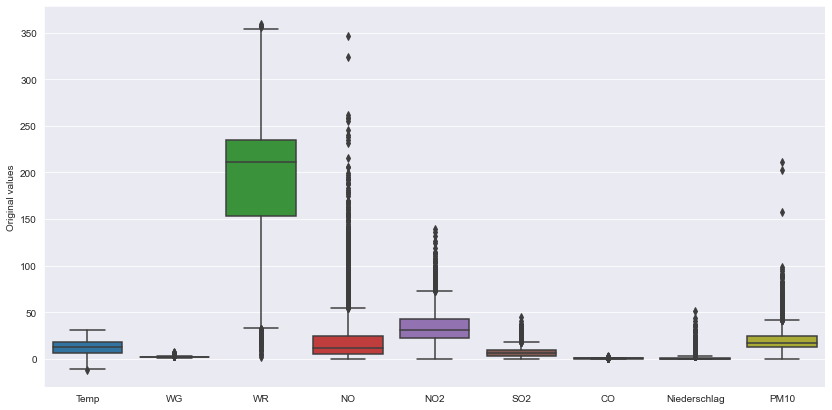

In [39]:
plt.figure(figsize=(14,7))
sb.set_style("darkgrid")
sb.boxplot(data=df_for_ML.drop(columns=["Datum","Druck"]))
#plt.title("Distribution of normalized temperature, humidity and windspeed")
plt.ylabel("Original values")
plt.show()

### Data Scaling and Normalization

#### Data Preparation

In [40]:
type(df_for_ML.Datum[0])

pandas._libs.tslibs.timestamps.Timestamp

#### Data Normalization

In [41]:
df_for_ML_woDate = df_for_ML.drop('Datum', axis=1)
x = df_for_ML_woDate.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_for_ML_norm = pd.DataFrame(x_scaled)

In [42]:
df_for_ML_norm.head()

,0,1,2,3,4,5,6,7,8,9
0,0.353183,0.207442,0.650876,0.694836,0.050829,0.174611,0.232267,0.299669,0.070239,0.053742
1,0.356214,0.239936,0.616148,0.774648,0.041178,0.206758,0.240322,0.291595,0.068908,0.058560
2,0.300606,0.258592,0.609629,0.763693,0.054985,0.254582,0.230253,0.275515,0.016434,0.094228
3,0.381534,0.453811,0.611599,0.665102,0.023764,0.174424,0.300291,0.256191,0.029147,0.054218
4,0.427769,0.249744,0.610672,0.661972,0.032680,0.188818,0.319311,0.393616,0.084540,0.061058


In [43]:
i = 0
dictColumn = {}
for i in range(0,(len(df_for_ML_woDate.columns))):
    dictColumn.update({list(df_for_ML_norm.columns)[i]:list(df_for_ML_woDate.columns)[i]})
    i=i+1
dictColumn

{0: 'Temp',
 1: 'WG',
 2: 'WR',
 3: 'Druck',
 4: 'NO',
 5: 'NO2',
 6: 'SO2',
 7: 'CO',
 8: 'Niederschlag',
 9: 'PM10'}

In [44]:
df_for_ML_norm=df_for_ML_norm.rename(columns=dictColumn)


In [45]:
df_for_ML_Date = df_for_ML[['Datum']]

In [46]:
df_for_ML_norm = pd.concat([df_for_ML_Date, df_for_ML_norm], axis=1, sort=False)

In [47]:
df_for_ML_norm.head()

,Datum,Temp,WG,WR,Druck,NO,NO2,SO2,CO,Niederschlag,PM10
0,2000-01-01,0.353183,0.207442,0.650876,0.694836,0.050829,0.174611,0.232267,0.299669,0.070239,0.053742
1,2000-01-02,0.356214,0.239936,0.616148,0.774648,0.041178,0.206758,0.240322,0.291595,0.068908,0.058560
2,2000-01-03,0.300606,0.258592,0.609629,0.763693,0.054985,0.254582,0.230253,0.275515,0.016434,0.094228
3,2000-01-04,0.381534,0.453811,0.611599,0.665102,0.023764,0.174424,0.300291,0.256191,0.029147,0.054218
4,2000-01-05,0.427769,0.249744,0.610672,0.661972,0.032680,0.188818,0.319311,0.393616,0.084540,0.061058


In [48]:
df_for_ML_norm.describe()

,Temp,WG,WR,Druck,NO,NO2,SO2,CO,Niederschlag,PM10
count,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000,7458.000000
mean,0.547148,0.210694,0.536614,0.585878,0.059508,0.241779,0.148389,0.145977,0.027980,0.092513
std,0.172872,0.110912,0.172077,0.120905,0.077393,0.116046,0.106886,0.100156,0.065692,0.051970
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.412433,0.137288,0.423653,0.519327,0.015150,0.160375,0.070223,0.068613,0.000000,0.058957
50%,0.551061,0.183051,0.584139,0.594679,0.032146,0.224604,0.133360,0.124904,0.001174,0.081767
75%,0.679879,0.259323,0.649663,0.663537,0.072134,0.306268,0.204806,0.203203,0.024853,0.113996
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


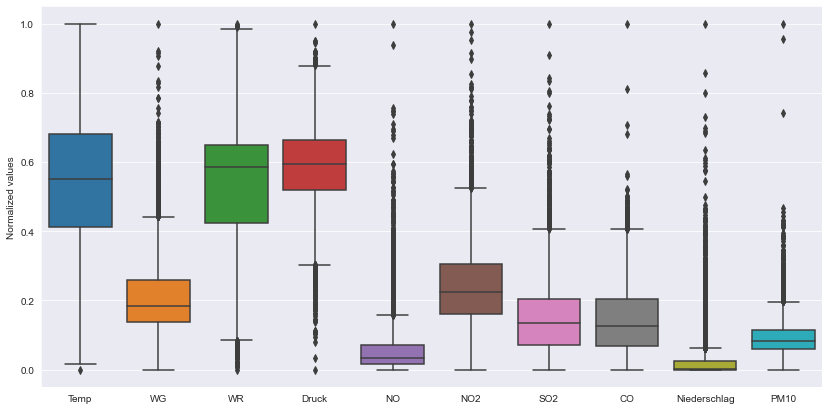

In [49]:
plt.figure(figsize=(14,7))
sb.set_style("darkgrid")
sb.boxplot(data=df_for_ML_norm.drop(columns=["Datum"]))
#plt.title("Distribution of normalized temperature, humidity and windspeed")
plt.ylabel("Normalized values")
plt.show()

### Split Data

#### Split Data into Training and Validation Samples

In [50]:
df_train=df_for_ML_norm[df_for_ML_norm["Datum"]<="2015-12-31"]
df_test=df_for_ML_norm[df_for_ML_norm["Datum"]>"2015-12-31"]


In [51]:
df_train.tail()

,Datum,Temp,WG,WR,Druck,NO,NO2,SO2,CO,Niederschlag,PM10
5840,2015-12-27,0.443693,0.076271,0.582820,0.732613,0.156867,0.267291,0.175775,0.159129,0.000000,0.074162
5841,2015-12-28,0.399394,0.106780,0.585618,0.703472,0.369963,0.336455,0.208655,0.346058,0.002544,0.089750
5842,2015-12-29,0.369084,0.106780,0.054841,0.691200,0.326592,0.340778,0.289116,0.253192,0.002544,0.093529
5843,2015-12-30,0.359758,0.106780,0.344432,0.682222,0.209779,0.283862,0.195968,0.242192,0.001566,0.108644
5844,2015-12-31,0.376078,0.030509,0.567991,0.623927,0.222791,0.260807,0.255818,0.181358,0.024658,0.125177


In [52]:
df_test.iloc[-1,:].Datum

Timestamp('2020-05-31 00:00:00')

In [53]:
df_test.tail()

,Datum,Temp,WG,WR,Druck,NO,NO2,SO2,CO,Niederschlag,PM10
7453,2020-05-27,0.669853,0.167797,0.586738,0.824570,0.017501,0.156340,0.262144,0.038219,0.0,0.057185
7454,2020-05-28,0.669853,0.274577,0.071908,0.767606,0.012007,0.169308,0.047673,0.032469,0.0,0.065848
7455,2020-05-29,0.644206,0.244068,0.354505,0.720344,0.007959,0.134726,0.196832,0.050656,0.0,0.102173
7456,2020-05-30,0.637211,0.274577,0.069110,0.658216,0.006803,0.132565,0.065723,0.035967,0.0,0.061918
7457,2020-05-31,0.655864,0.213560,0.164242,0.639593,0.004490,0.093660,0.087232,0.035932,0.0,0.054709


def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [54]:
df_test=df_test.drop(columns=["Datum"])
df_train=df_train.drop(columns=["Datum"])

#### Split Data into Input and Target Data

In [55]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i+time_steps]
        Xs.append(v)        
        ys.append(labels)
    return np.array(Xs), np.array(ys)

In [56]:
TIME_STEPS = 21
STEP = 1

X_train, y_train = create_dataset(
    #df_train.drop(columns=['PM10']), 
    df_train,
    df_train.PM10, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    #df_test.drop(columns=['PM10']),
    df_test,
    df_test.PM10, 
    TIME_STEPS, 
    STEP
)

In [57]:
df_for_ML.head(3)

,Datum,Temp,WG,WR,Druck,NO,NO2,SO2,CO,Niederschlag,PM10
0,2000-01-01,3.718,1.959896,234.922917,991.8,17.6266,24.236,10.38,0.9109,3.5892,11.3772
1,2000-01-02,3.848,2.172912,222.511250,996.9,14.2886,28.698,10.74,0.8870,3.5212,12.3972
2,2000-01-03,1.463,2.295208,220.181250,996.2,19.0638,35.336,10.29,0.8394,0.8398,19.9480


In [58]:
X_train[0]

array([[3.53182560e-01, 2.07442177e-01, 6.50875536e-01, 6.94835681e-01,
        5.08290840e-02, 1.74610951e-01, 2.32266726e-01, 2.99668600e-01,
        7.02387476e-02, 5.37420879e-02],
       [3.56213570e-01, 2.39936313e-01, 6.16147874e-01, 7.74647887e-01,
        4.11775785e-02, 2.06757925e-01, 2.40322220e-01, 2.91594739e-01,
        6.89080235e-02, 5.85602267e-02],
       [3.00606202e-01, 2.58591650e-01, 6.09628567e-01, 7.63693271e-01,
        5.49846093e-02, 2.54582133e-01, 2.30252853e-01, 2.75514582e-01,
        1.64344423e-02, 9.42276807e-02],
       [3.81534157e-01, 4.53811343e-01, 6.11598816e-01, 6.65101721e-01,
        2.37638107e-02, 1.74423631e-01, 3.00290893e-01, 2.56191367e-01,
        2.91467710e-02, 5.42182333e-02],
       [4.27768711e-01, 2.49744173e-01, 6.10671983e-01, 6.61971831e-01,
        3.26797431e-02, 1.88818444e-01, 3.19310808e-01, 3.93615907e-01,
        8.45401174e-02, 6.10581011e-02],
       [3.58451854e-01, 2.13299816e-01, 5.77553162e-01, 6.51017214e-01,
   

In [59]:
type(df_train["PM10"].iloc[2])

numpy.float64

In [60]:
X_train.shape

(5824, 21, 10)

In [61]:
y_train.shape

(5824,)

In [62]:
df_for_ML.tail(3)

,Datum,Temp,WG,WR,Druck,NO,NO2,SO2,CO,Niederschlag,PM10
7455,2020-05-29,16.2,2.2,129.0,993.43,2.8,18.7,8.79640,0.173780,0.0,21.630
7456,2020-05-30,15.9,2.4,27.0,989.46,2.4,18.4,2.93716,0.130298,0.0,13.108
7457,2020-05-31,16.7,2.0,61.0,988.27,1.6,13.0,3.89840,0.130196,0.0,11.582


In [63]:
X_test[-1]

array([[0.71881557, 0.22881404, 0.58114158, 0.43114241, 0.00535713,
        0.1037464 , 0.07305437, 0.20027769, 0.02739726, 0.10901275],
       [0.52529727, 0.25932258, 0.93088976, 0.39499218, 0.0079594 ,
        0.11959654, 0.10448623, 0.15277501, 0.40313112, 0.05818706],
       [0.46467708, 0.16779697, 0.58114158, 0.58607199, 0.01692275,
        0.12175793, 0.20297158, 0.08153518, 0.        , 0.05780822],
       [0.48332945, 0.13728843, 0.30134303, 0.50328638, 0.01721189,
        0.16642651, 0.20917879, 0.08187705, 0.09001957, 0.10516769],
       [0.52762882, 0.16779697, 0.0970901 , 0.54538341, 0.0108508 ,
        0.15345821, 0.2040725 , 0.05065587, 0.01565558, 0.07270666],
       [0.58358592, 0.24406831, 0.57834359, 0.58716745, 0.00506799,
        0.12319885, 0.19946297, 0.08871923, 0.        , 0.04752008],
       [0.59058055, 0.13728843, 0.60072748, 0.65633803, 0.00911596,
        0.14337176, 0.20684269, 0.11417925, 0.        , 0.05498347],
       [0.6185591 , 0.16779697, 0.6035254

In [64]:
y_test[-1]

0.0547094945677846

## Alogrithms Selection

## Baseline Models

## Deep Learning Models

In [65]:
X_train.shape

(5824, 21, 10)

In [66]:
print(X_train.shape)
print(y_train.shape)

(5824, 21, 10)
(5824,)


In [67]:
print(X_train.ndim)
print(y_train.ndim)

3
1


In [68]:
print(X_train.dtype)
print(y_train.dtype)

float64
float64


In [69]:
X_train.shape[1]

21

In [70]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(5824, 21, 10)

In [71]:
model = Sequential()
model.add(layers.LSTM(units=200, 
                      return_sequences= True,
                      activation ='tanh', 
                      input_shape=(TIME_STEPS,10)))
model.add(layers.Flatten())
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 21, 200)           168800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4201      
Total params: 173,001
Trainable params: 173,001
Non-trainable params: 0
_________________________________________________________________


In [72]:
y_train.reshape(-1,1)

array([[0.05331129],
       [0.06192348],
       [0.16478035],
       ...,
       [0.09352858],
       [0.10864431],
       [0.12517714]])

In [73]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5824, 21, 10)
(5824,)
(1592, 21, 10)
(1592,)


In [74]:
model.compile(optimizer='RMSprop', loss='mae',metrics=["accuracy"])
history = model.fit(x=X_train, y=y_train, epochs=15, validation_data=(X_test, y_test))

Train on 5824 samples, validate on 1592 samples
Epoch 1/15
5824/5824 [==============================] - 5s 848us/step - loss: 0.0476 - accuracy: 8.5852e-04 - val_loss: 0.0280 - val_accuracy: 0.0000e+00
Epoch 2/15
5824/5824 [==============================] - 6s 955us/step - loss: 0.0315 - accuracy: 8.5852e-04 - val_loss: 0.0305 - val_accuracy: 0.0000e+00
Epoch 3/15
5824/5824 [==============================] - 6s 1ms/step - loss: 0.0293 - accuracy: 8.5852e-04 - val_loss: 0.0259 - val_accuracy: 0.0000e+00
Epoch 4/15
5824/5824 [==============================] - 6s 977us/step - loss: 0.0281 - accuracy: 8.5852e-04 - val_loss: 0.0281 - val_accuracy: 0.0000e+00
Epoch 5/15
5824/5824 [==============================] - 7s 1ms/step - loss: 0.0277 - accuracy: 8.5852e-04 - val_loss: 0.0248 - val_accuracy: 0.0000e+00
Epoch 6/15
5824/5824 [==============================] - 9s 1ms/step - loss: 0.0268 - accuracy: 8.5852e-04 - val_loss: 0.0243 - val_accuracy: 0.0000e+00
Epoch 7/15
5824/5824 [============

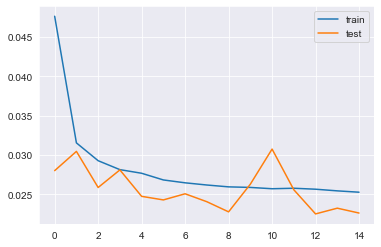

In [75]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Hyperparamters Optimization

## Evaluation

### Model Evaluation (Performance)

#### Training Phase

#### Testing Phase

# Projekt Evaluation

# Deployment

In the first phase of CRISP the overall business-case, which shall be supported by the data mining process must be clearly defined and understood. Then the goal of the data mining project itself must be defined. This includes the specification of metrics for measuring the performance of the data mining project.

In the second phase data must be gathered, accessed, understood and described. Quantitiy and qualitity of the data must be assessed on a high-level.

In the third phase data must be investigated and understood more thoroughly. Common means for understanding data are e.g. visualization and the calculation of simple statistics. Outliers must be detected and processed, sampling rates must be determined, features must be selected and eventually be transformed to other formats.

In the modelling phase various algorithms and their hyperparameters are selected and applied. Their performance on the given data is determined in the evaluation phase.

The output of the evaluation is usually fed back to the first phases (business- and data-understanding). Applying this feedback the techniques in the overall process are adapted and optimized. Usually only after several iterations of this process the evaluation yields good results and the project can be deployed.